In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from get_census_data import query_census_api

<Response [200]>


Query Census API to get, inter alia, the number of employer firms and total number of employees at those firms, broken down by the race of the majority firm owner and the industry classification

In [2]:
query_res1 = query_census_api('abscs', 'GEO_ID', 'NAME', 'NAICS2017', 'NAICS2017_LABEL', 'RACE_GROUP', 'RACE_GROUP_LABEL', 'FIRMPDEMP', 'EMP', geography='us')

Check status of query

In [3]:
print(query_res1)

<Response [200]>


In [4]:
firms_df = pd.DataFrame.from_dict(query_res1.json())
firms_df.columns = firms_df.iloc[0]
firms_df.drop(index=0, inplace=True)
firms_df.head()

,GEO_ID,NAME,NAICS2017,NAICS2017_LABEL,RACE_GROUP,RACE_GROUP_LABEL,FIRMPDEMP,EMP,us
1,0100000US,United States,00,Total for all sectors,00,Total,5722142,128196406,1
2,0100000US,United States,00,Total for all sectors,40,Black or African American,124551,1188819,1
3,0100000US,United States,00,Total for all sectors,30,White,4769883,56877432,1
4,0100000US,United States,00,Total for all sectors,50,American Indian and Alaska Native,24433,200256,1
5,0100000US,United States,00,Total for all sectors,60,Asian,577835,5090065,1


The first question I want to examine is how firm ownership varies by race, will do this by looking at a bargraph

In [5]:
num_firms_by_race = firms_df.loc[firms_df['NAICS2017'] == '00'][['RACE_GROUP_LABEL', 'FIRMPDEMP']]
num_firms_by_race.rename(columns={'RACE_GROUP_LABEL':"Owner Race", 'FIRMPDEMP': "Number of Firms"}, inplace=True)
num_firms_by_race.set_index(num_firms_by_race['Owner Race'], inplace=True)
num_firms_by_race.drop(columns='Owner Race', inplace=True)
num_firms_by_race['Number of Firms'] = num_firms_by_race['Number of Firms'].astype(int)

num_firms_by_race

,Number of Firms
Owner Race,
Total,5722142
Black or African American,124551
White,4769883
American Indian and Alaska Native,24433
Asian,577835
Minority,1048323
Native Hawaiian and Other Pacific Islander,6653
Equally minority/nonminority,86633
Nonminority,4364169


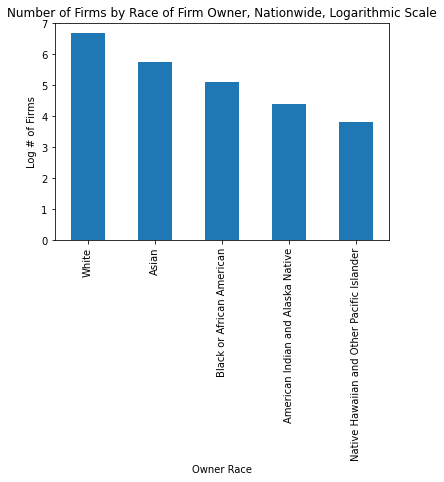

In [6]:
plot_races = ['Black or African American', 'White', 'American Indian and Alaska Native', 'Asian', 'Native Hawaiian and Other Pacific Islander']

ax = num_firms_by_race.loc[plot_races]['Number of Firms'].sort_values(ascending=False).apply(np.log10).plot.bar()
ax.set_ylabel("Log # of Firms")

plt.title("Number of Firms by Race of Firm Owner, Nationwide, Logarithmic Scale")
plt.show()

The thing I'd like to examine is the relationship between the race of the firm owner, and the industry classification of the firm. Do certain races own different kinds of firms at disproportionate rates?

In [7]:
no_totals_df = firms_df[firms_df['RACE_GROUP_LABEL'] != 'Total']

industry_race_pivot = no_totals_df.pivot(index='NAICS2017_LABEL', columns='RACE_GROUP_LABEL', values='FIRMPDEMP').apply(lambda col: col.apply(lambda x: int(x)), axis=1)

In [8]:
industry_race_pivot_pct = industry_race_pivot.apply(lambda col: col.apply(lambda x: 100*x/col.loc['Total for all sectors']), axis=0)

industry_race_pivot_pct.drop(index='Total for all sectors', columns=['Equally minority/nonminority', 'Minority', 'Nonminority'], inplace=True)
industry_race_pivot_pct

RACE_GROUP_LABEL,American Indian and Alaska Native,Asian,Black or African American,Native Hawaiian and Other Pacific Islander,White
NAICS2017_LABEL,,,,,
Accommodation and food services,7.309786,24.530532,6.193447,8.041485,7.778765
Administrative and support and waste management and remediation services,7.358900,2.159267,8.798805,5.907110,6.533389
"Agriculture, forestry, fishing and hunting",0.000000,0.000000,0.000000,0.315647,0.511711
"Arts, entertainment, and recreation",0.000000,0.752291,2.641488,0.000000,2.097599
Construction,18.626448,2.701290,7.098297,16.443710,14.241691
Educational services,0.000000,1.231666,1.888383,0.000000,1.174683
Finance and insurance,4.240167,1.508735,4.525857,0.000000,4.391743
Health care and social assistance,10.211599,13.564945,28.540116,0.000000,9.617993
Industries not classified,0.495232,0.098298,0.195101,0.616263,0.423176


[Text(0.5, 1.0, 'Percentage of Employer Firms by Race and Industry'),
 Text(0.5, 15.0, 'Race of Firm Majority Owner'),
 Text(32.99999999999998, 0.5, 'Industry')]

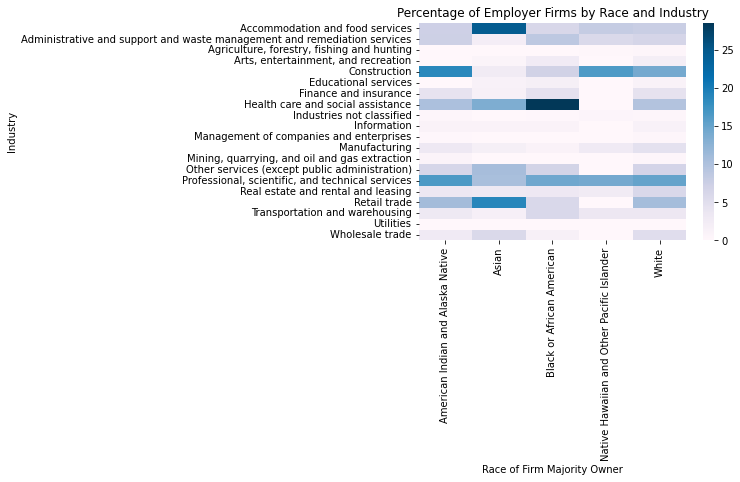

In [9]:
sns.heatmap(industry_race_pivot_pct, cmap='PuBu').set(title="Percentage of Employer Firms by Race and Industry", xlabel="Race of Firm Majority Owner", ylabel="Industry")

Average number of Employees per Firms variation by Race

In [10]:
emp_per_firm_by_race = firms_df[['NAICS2017_LABEL', 'RACE_GROUP_LABEL', 'FIRMPDEMP', 'EMP']].loc[firms_df['RACE_GROUP_LABEL'] != 'Total'].loc[:9]

emp_per_firm_by_race[['FIRMPDEMP', 'EMP']] = emp_per_firm_by_race[['FIRMPDEMP', 'EMP']].apply(pd.to_numeric)

In [11]:
emp_per_firm_by_race['avg emp per firm'] = emp_per_firm_by_race['EMP']/emp_per_firm_by_race['FIRMPDEMP']
plot_data = emp_per_firm_by_race.set_index('RACE_GROUP_LABEL')['avg emp per firm']

emp_per_firm_by_race

,NAICS2017_LABEL,RACE_GROUP_LABEL,FIRMPDEMP,EMP,avg emp per firm
2,Total for all sectors,Black or African American,124551,1188819,9.544837
3,Total for all sectors,White,4769883,56877432,11.924282
4,Total for all sectors,American Indian and Alaska Native,24433,200256,8.196128
5,Total for all sectors,Asian,577835,5090065,8.808855
6,Total for all sectors,Minority,1048323,9432081,8.997304
7,Total for all sectors,Native Hawaiian and Other Pacific Islander,6653,54446,8.183677
8,Total for all sectors,Equally minority/nonminority,86633,843404,9.735366
9,Total for all sectors,Nonminority,4364169,53190299,12.187956


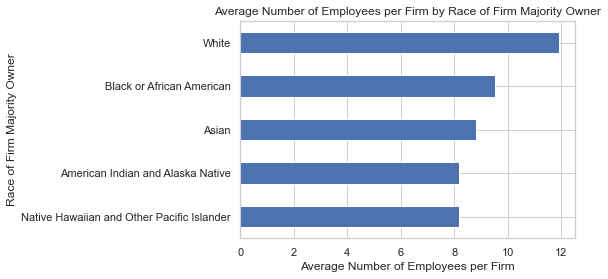

In [12]:
sns.set_theme(style="whitegrid")

ax = plot_data[plot_races].sort_values().plot.barh()

ax.set_xlabel("Average Number of Employees per Firm")
ax.set_ylabel("Race of Firm Majority Owner")

plt.title("Average Number of Employees per Firm by Race of Firm Majority Owner")
plt.show()